In [1]:
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ['CUDA_VISIBLE_DEVICES'] = '1'
import tensorflow as tf
from tensorflow import keras
import cv2
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import LabelBinarizer
import shutil
import json
import numpy as np
from sklearn.model_selection import train_test_split
from skimage.filters import unsharp_mask
from sklearn.metrics import accuracy_score
from tensorflow.keras.layers import Input, GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.regularizers import l2
from tensorflow.keras import layers
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.python.keras import Sequential, Model
from tensorflow.python.keras.optimizers import Adam
from skimage.filters import unsharp_mask
from tensorflow.keras.preprocessing import image
from scipy.ndimage.filters import gaussian_filter, gaussian_laplace 
from dataset.generate_dataset import GenerateDataset
from dataset.ImageDatasetGenerator import ImageDatasetGenerator
from layers.PreprocessImage import PreprocessImage
from layers.UnsharpMaskLog import UnsharpMaskLoG
from layers.UnsharpMask import UnsharpMask
from layers.UnsharpMaskFixedLambda import UnsharpMaskFixedLambda
from optimizers.LearningRateMultiplier import LearningRateMultiplier
import json
from tensorflow.keras import backend as K
import tensorflow as tf

In [2]:
pd.set_option("display.max_rows", 2000)
pd.set_option('display.max_colwidth', 200)
pd.set_option('display.max_columns', 200)
pd.set_option('max_colwidth', 200)
pd.set_option('display.float_format', lambda x: '%.5f' % x)

In [3]:
def show_images(images, cols = 1, titles = None):
    """Display a list of images in a single figure with matplotlib.
    
    Parameters
    ---------
    images: List of np.arrays compatible with plt.imshow.
    
    cols (Default = 1): Number of columns in figure (number of rows is 
                        set to np.ceil(n_images/float(cols))).
    
    titles: List of titles corresponding to each image. Must have
            the same length as titles.
    """
    assert((titles is None)or (len(images) == len(titles)))
    n_images = len(images)
    if titles is None: titles = ['Image (%d)' % i for i in range(1,n_images + 1)]
    fig = plt.figure()
    for n, (image, title) in enumerate(zip(images, titles)):
        a = fig.add_subplot(cols, np.ceil(n_images/float(cols)), n + 1)
        if image.ndim == 2:
            plt.gray()
        plt.imshow(image)
        a.set_title(title, fontsize=25)
    fig.set_size_inches(np.array(fig.get_size_inches()) * n_images)
    plt.show()
    
def plot_weights(history):
    # list all data in history
    plt.plot(history['amount'])
    plt.title('amount optimization')
    plt.ylabel('amount')
    plt.xlabel('epoch')
    plt.legend(['amount'], loc='upper left')
    plt.show()

def plot_history(experiments_history, metric, train=False):
    # list all data in history
    legends = []
    for legend, history in experiments_history.items():
        if train:
            plt.plot(history[metric])
            legends.append('%s train' % legend)
        val_metric = None
        if metric == 'amount':
            val_metric = 'amount'
        else:
            val_metric = 'val_%s' % metric
        plt.plot(history[val_metric])
        legends.append('%s val' % legend)
    plt.title('models %s' % metric)
    plt.ylabel(metric)
    plt.xlabel('epoch')
    plt.legend(legends, bbox_to_anchor=(1.1, 1.05))
    plt.show()
    
'''
def plot_history(history):
    # list all data in history
    plt.plot(history['top_k_categorical_accuracy'])
    plt.plot(history['val_top_k_categorical_accuracy'])
    plt.title('model top_k_categorical_accuracy')
    plt.ylabel('top_k_categorical_accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    plt.plot(history['acc'])
    plt.plot(history['val_acc'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    # summarize history for loss
    plt.plot(history['loss'])
    plt.plot(history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
'''

"\ndef plot_history(history):\n    # list all data in history\n    plt.plot(history['top_k_categorical_accuracy'])\n    plt.plot(history['val_top_k_categorical_accuracy'])\n    plt.title('model top_k_categorical_accuracy')\n    plt.ylabel('top_k_categorical_accuracy')\n    plt.xlabel('epoch')\n    plt.legend(['train', 'test'], loc='upper left')\n    plt.show()\n    plt.plot(history['acc'])\n    plt.plot(history['val_acc'])\n    plt.title('model accuracy')\n    plt.ylabel('accuracy')\n    plt.xlabel('epoch')\n    plt.legend(['train', 'test'], loc='upper left')\n    plt.show()\n    # summarize history for loss\n    plt.plot(history['loss'])\n    plt.plot(history['val_loss'])\n    plt.title('model loss')\n    plt.ylabel('loss')\n    plt.xlabel('epoch')\n    plt.legend(['train', 'test'], loc='upper left')\n    plt.show()\n"

In [5]:
dataset_output = {}

input_folder = '/notebooks/food-11'
train_folder = os.path.join(input_folder, 'training')


classes = [str(i) for i in range(11)] 
classes.sort()
dataset_output['classes'] = classes

metadata = {}
mapping = {'training': 'train', 'validation': 'val', 'evaluation': 'test'}
for dataset in os.listdir(input_folder):
    dataset_path = os.path.join(input_folder, dataset)
    files = []
    labels = []
    images = os.listdir(dataset_path)
    for i, image in enumerate(images):
        image_path = os.path.join(dataset_path, image)
        label = image.split('_')[0]
        labels.append(classes.index(label))
        files.append(image_path)
        metadata[image] = {"specimen_number": str(i), "label": label}
    dataset_output[mapping[dataset]] = {"files": files, 'labels': labels} 

In [256]:
with open('/notebooks/food.metadata', 'w') as file:
    json.dump(metadata, file)
with open('/notebooks/dataset_food.json', 'w') as file:
    json.dump(dataset_output, file)

In [248]:
dataset_output = {}

input_folder = '/notebooks/HojasCR224'
train_folder = os.path.join(input_folder, 'train')

classes = os.listdir(train_folder)
classes.sort()
dataset_output['classes'] = classes

metadata = {}
 
for dataset in os.listdir(input_folder):
    dataset_path = os.path.join(input_folder, dataset)
    files = []
    labels = []
    species = os.listdir(dataset_path)
    for specie in species:
        specie_path = os.path.join(dataset_path, specie)
        for specimen_number, file in enumerate(os.listdir(specie_path)):
            labels.append(classes.index(specie))
            files.append(os.path.join(specie_path, file))
            metadata[file] = {"specimen_number": str(specimen_number), "label": specie}
    dataset_output[dataset] = {"files": files, 'labels': labels} 

In [249]:
with open('/notebooks/hojas.metadata', 'w') as file:
    json.dump(metadata, file)
with open('/notebooks/dataset_hojas.json', 'w') as file:
    json.dump(dataset_output, file)

In [21]:
input_folder = '/notebooks/BarkNet 1.0'
import os
data = {}

for class_name in os.listdir(input_folder):
    class_path = os.path.join(input_folder, class_name)
    for file_name in os.listdir(class_path):
        specimen_number = file_name.split("_")[0]
        label = file_name.split("_")[1]
        data[file_name] = {'specimen_number': specimen_number, 'label': label}
data

{'792_FRA_110_GalaxyS5_20170713_105752_6.jpg': {'label': 'FRA',
  'specimen_number': '792'},
 '866_MEL_70_GalaxyS5_20170706_120304_14.jpg': {'label': 'MEL',
  'specimen_number': '866'},
 '481_CHR_137_GalaxyS7_20170916_143231_12.jpg': {'label': 'CHR',
  'specimen_number': '481'},
 '255_FRA_114_Nexus 5_20170804_101859_3.jpg': {'label': 'FRA',
  'specimen_number': '255'},
 '520_CHR_188_GalaxyS7_20170916_181952_9.jpg': {'label': 'CHR',
  'specimen_number': '520'},
 '599_FRA_121_GalaxyS7_20170607_140202_2.jpg': {'label': 'FRA',
  'specimen_number': '599'},
 '604_FRA_123_GalaxyS5_20170607_150947_6.jpg': {'label': 'FRA',
  'specimen_number': '604'},
 '275_HEG_72_Nexus 5_20170608_091404_7.jpg': {'label': 'HEG',
  'specimen_number': '275'},
 '544_ERR_23_GalaxyS7_20170922_122730_18.jpg': {'label': 'ERR',
  'specimen_number': '544'},
 '827_MEL_76_GalaxyS5_20170706_104740_3.jpg': {'label': 'MEL',
  'specimen_number': '827'},
 '767_ERR_63_GalaxyS5_20170706_122640_20.jpg': {'label': 'ERR',
  'specim

In [59]:
import pandas as pd

df_metadatos = pd.read_csv('/notebooks/Proyecto_maderas_base_datos_Geo.csv')
df_metadatos.head()

,FAMILIA,GENERO,ESPECIE,ID_ESPECIE,GIRA,ID _ESPECIMEN,ID_CUBO,CONDICION,CORTE,ID_FOTO
0,Fabaceae,Albizia,adinocephala,1,1.0,31,1,0,1,670
1,Fabaceae,Albizia,adinocephala,1,1.0,31,2,0,1,673
2,Fabaceae,Albizia,adinocephala,1,1.0,31,1,0,0,671
3,Fabaceae,Albizia,adinocephala,1,1.0,31,2,0,0,674
4,Fabaceae,Albizia,adinocephala,1,1.0,31,1,0,2,672


In [60]:
df_dataset = df_metadatos[(df_metadatos['CONDICION'] == 0) & (df_metadatos['CORTE'] == 0)]
df_dataset.head(2)

,FAMILIA,GENERO,ESPECIE,ID_ESPECIE,GIRA,ID _ESPECIMEN,ID_CUBO,CONDICION,CORTE,ID_FOTO
2,Fabaceae,Albizia,adinocephala,1,1.0,31,1,0,0,671
3,Fabaceae,Albizia,adinocephala,1,1.0,31,2,0,0,674


In [131]:
species_data = [int(specie) for specie in os.listdir('/notebooks/Madera_76_Especies/allData/')]
species_data

[135,
 107,
 119,
 137,
 148,
 27,
 45,
 99,
 147,
 58,
 139,
 93,
 65,
 117,
 105,
 20,
 113,
 82,
 144,
 43,
 74,
 7,
 55,
 29,
 102,
 10,
 3,
 142,
 131,
 17,
 121,
 2,
 18,
 31,
 101,
 25,
 13,
 114,
 143,
 44,
 122,
 104,
 23,
 116,
 48,
 88,
 49,
 85,
 28,
 21,
 100,
 140,
 70,
 118,
 126,
 127,
 136,
 30,
 125,
 57,
 138,
 115,
 5,
 63,
 77,
 46,
 80,
 84,
 89,
 94,
 106,
 75,
 83,
 81,
 9,
 120]

In [133]:
df_metadatos = df_metadatos[df_metadatos['ID_ESPECIE'].isin(species_data)]

In [134]:
df_metadatos[df_metadatos['ID_FOTO'] == 7802]

,FAMILIA,GENERO,ESPECIE,ID_ESPECIE,GIRA,ID _ESPECIMEN,ID_CUBO,CONDICION,CORTE,ID_FOTO,filename,genero_specie
7333,Fabaceae,Schyzolobium,parahyba,21,8.0,252,2,0,0,7802,7802.jpg,Schyzolobium parahyba Fabaceae


In [135]:
df_metadatos['filename'] = df_metadatos['ID_FOTO'].apply(lambda x: '{}.jpg'.format(x))
df_metadatos['genero_specie'] = df_metadatos.apply(lambda x: '{} {} {}'.format(x['GENERO'], x['ESPECIE'], x['FAMILIA']), axis=1)


In [136]:
df_metadatos['genero_specie'].head()

60    Cederla odorata Meliaceas
61    Cederla odorata Meliaceas
62    Cederla odorata Meliaceas
63    Cederla odorata Meliaceas
64    Cederla odorata Meliaceas
Name: genero_specie, dtype: object

In [137]:
df_metadatos.columns

Index(['FAMILIA', 'GENERO', 'ESPECIE', 'ID_ESPECIE', 'GIRA', 'ID _ESPECIMEN',
       'ID_CUBO', 'CONDICION', 'CORTE', 'ID_FOTO', 'filename',
       'genero_specie'],
      dtype='object')

In [138]:
df_metadatos.shape

(15798, 12)

In [139]:
len(set(df_metadatos['ID_FOTO']))

15694

In [141]:
df_especimens = df_metadatos.groupby('ID_ESPECIE').agg({'ID _ESPECIMEN': lambda x: len(set(x))}).sort_values('ID _ESPECIMEN', ascending=False).reset_index(False)
top_especimens = df_especimens[df_especimens['ID _ESPECIMEN'] >= 5]

top_especimens

,ID_ESPECIE,ID _ESPECIMEN
0,17,16
1,2,15
2,21,13
3,84,12
4,74,12
5,10,12
6,46,12
7,114,10
8,55,10
9,85,10


In [142]:
final_metadata_maderas = {}
list_dict_maderas = df_metadatos[['ID_ESPECIE', 'ID _ESPECIMEN', 'filename']].to_dict('records')
for dict_val in list_dict_maderas:
    final_metadata_maderas[dict_val['filename']] = {'specimen_number': str(dict_val['ID _ESPECIMEN']), 'label': str(dict_val['ID_ESPECIE'])}
    
final_metadata_maderas

{'2741.jpg': {'label': '85', 'specimen_number': '103'},
 '5201.jpg': {'label': '7', 'specimen_number': '185'},
 '14539.jpg': {'label': '120', 'specimen_number': '476'},
 '14076.jpg': {'label': '119', 'specimen_number': '453'},
 '13739.jpg': {'label': '104', 'specimen_number': '463'},
 '14122.jpg': {'label': '119', 'specimen_number': '454'},
 '12920.jpg': {'label': '114', 'specimen_number': '436'},
 '5923.jpg': {'label': '45', 'specimen_number': '210'},
 '3837.jpg': {'label': '58', 'specimen_number': '138'},
 '11413.jpg': {'label': '48', 'specimen_number': '392'},
 '18209.jpg': {'label': '139', 'specimen_number': '591'},
 '9119.jpg': {'label': '21', 'specimen_number': '297'},
 '14275.jpg': {'label': '113', 'specimen_number': '459'},
 '3054.jpg': {'label': '46', 'specimen_number': '141'},
 '14052.jpg': {'label': '80', 'specimen_number': '472'},
 '1168.jpg': {'label': '17', 'specimen_number': '33'},
 '12694.jpg': {'label': '126', 'specimen_number': '510'},
 '4204.jpg': {'label': '70', 'sp

In [143]:
import json
with open('/notebooks/maderas.metadata', 'w') as outfile:
    json.dump(final_metadata_maderas, outfile)

In [5]:
import os 
species = os.listdir('/notebooks/Madera_76_Especies/allData/')
species

['135',
 '107',
 '119',
 '137',
 '148',
 '27',
 '45',
 '99',
 '147',
 '58',
 '139',
 '93',
 '65',
 '117',
 '105',
 '20',
 '113',
 '82',
 '144',
 '43',
 '74',
 '7',
 '55',
 '29',
 '102',
 '10',
 '3',
 '142',
 '131',
 '17',
 '121',
 '2',
 '18',
 '31',
 '101',
 '25',
 '13',
 '114',
 '143',
 '44',
 '122',
 '104',
 '23',
 '116',
 '48',
 '88',
 '49',
 '85',
 '28',
 '21',
 '100',
 '140',
 '70',
 '118',
 '126',
 '127',
 '136',
 '30',
 '125',
 '57',
 '138',
 '115',
 '5',
 '63',
 '77',
 '46',
 '80',
 '84',
 '89',
 '94',
 '106',
 '75',
 '83',
 '81',
 '9',
 '120']

In [23]:
import json
with open('/notebooks/barknet.metadata', 'w') as outfile:
    json.dump(data, outfile)

In [55]:
import json
with open('/notebooks/barknet.metadata', 'r') as outfile:
    x = json.load(outfile)

In [57]:
len(x) * 0.8

18892.8

In [27]:
data = pd.read_csv('bark.csv', sep=';')
data['filename'] = data['filename'].apply(lambda x: x.split("/")[-1])
data.head()

,url,speciesid,species,genus,family,observationid,author,longitude,latitude,tag,learntag,filename
0,https://bs.plantnet-project.org/th/m/6d73bbdf3...,100209,Protium gallicum Daly,Protium,Burseraceae,4d1906bf0fdf63c42874ca6739013063,R. Tournebize,-53.4,5.2,Bark,Train,6d73bbdf325458b0e34a9978880f5cad49365b85.jpg
1,https://bs.plantnet-project.org/th/m/842fd2f20...,100209,Protium gallicum Daly,Protium,Burseraceae,4d1906bf0fdf63c42874ca6739013063,R. Tournebize,-53.4,5.2,Bark,Train,842fd2f2056a845b2aa8a0d8c7b51757ce388b1c.jpg
2,https://bs.plantnet-project.org/th/m/2f647d5f2...,100209,Protium gallicum Daly,Protium,Burseraceae,4d1906bf0fdf63c42874ca6739013063,R. Tournebize,-53.4,5.2,Bark,Train,2f647d5f2afc0f67b7b6535a185be41bdfd4bbf3.jpg
3,https://bs.plantnet-project.org/th/m/fbfccdd62...,100209,Protium gallicum Daly,Protium,Burseraceae,4d1906bf0fdf63c42874ca6739013063,R. Tournebize,-53.4,5.2,Bark,Train,fbfccdd6247b428defeaf72fe93396817a6eaefd.jpg
4,https://bs.plantnet-project.org/th/m/902137b31...,100209,Protium gallicum Daly,Protium,Burseraceae,4d1906bf0fdf63c42874ca6739013063,R. Tournebize,-53.4,5.2,Bark,Train,902137b312ced9155afe1cab1b1167b6bed024d1.jpg


In [32]:
final_metadata = {}
list_dict = data[['species', 'observationid', 'filename']].to_dict('records')
for dict_val in list_dict:
    final_metadata[dict_val['filename']] = {'specimen_number': dict_val['observationid'], 'label': dict_val['species']}
    
final_metadata

{'a3c001f36bd7f3be7bcf7a5f63ade3f1760985c0.jpg': {'label': 'Licania densiflora Kleinhoonte',
  'specimen_number': 'b1aeb4fb9b62a4330e6c4fe6c743ceff'},
 'd296f1e9b583857471eeee53205bec6c19053189.jpg': {'label': 'Couratari oblongifolia Ducke & R.Knuth',
  'specimen_number': 'b1aeb4fb9b62a4330e6c4fe6c78d8250'},
 '558f486e9c3bcfc8a61259b710f55a018ca094eb.jpg': {'label': 'Hebepetalum humiriifolium (Planch.) Benth.',
  'specimen_number': 'b1aeb4fb9b62a4330e6c4fe6c7402f11'},
 '842e60dfa1c9a2c6e4eb86d3dee2f68995a6202f.jpg': {'label': 'Licania alba (Bernoulli) Cuatrec.',
  'specimen_number': 'b1aeb4fb9b62a4330e6c4fe6c79d1241'},
 '1a2f4d0ed3ec1783061c3299574a614abae48b66.jpg': {'label': 'Eschweilera congestiflora (Benoist) Eyma',
  'specimen_number': '4d1906bf0fdf63c42874ca673921f294'},
 '7b73ae9537fc82b3f37b73202b06b01fafb2e387.jpg': {'label': 'Duguetia surinamensis R.E.Fr.',
  'specimen_number': 'b1aeb4fb9b62a4330e6c4fe6c7ea3588'},
 '26f98076a5e37d77920dcb63c757e4f3696bbc60.jpg': {'label': 'Li

In [33]:
import json
with open('/notebooks/bdfr.metadata', 'w') as outfile:
    json.dump(final_metadata, outfile)

In [5]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import log_loss
from sklearn.metrics import precision_recall_fscore_support
from tensorflow.keras.models import load_model 
import math
from collections import OrderedDict
import re
from dataset.generate_dataset import GenerateDataset
from dataset.ImageDatasetGenerator import ImageDatasetGenerator
from layers.PreprocessImage import PreprocessImage
from layers.UnsharpMaskLog import UnsharpMaskLoG
from layers.UnsharpMask import UnsharpMask
from layers.UnsharpMaskFixedLambda import UnsharpMaskFixedLambda
from optimizers.LearningRateMultiplier import LearningRateMultiplier
import json

def get_probs_no_crops(n_images, probs_crops, idx_rows):
    probs_no_crops = []
    for i in range(n_images):
        probs_row = probs_crops[idx_rows[i]:idx_rows[i + 1]].mean(axis=0)
        probs_no_crops.append(probs_row)
    probs_no_crops = np.array(probs_no_crops)
    return probs_no_crops

def get_crops_and_labels(dataset, target_size=(224, 224), resize_dim=None):
    out_height, out_width = target_size
    indexes = []
    crops = []
    files = dataset['files']
    labels = dataset['labels']
    crops_labels = []
    idx_rows = [0]
    for path, label in zip(files, labels):
        img = cv2.imread(path)
        if resize_dim:
            img = cv2.resize(img, resize_dim)
        (height, width) = img.shape[0], img.shape[1]
        crops_height = height//out_height
        crops_width = width//out_width
        #print("Processing image in path: {}".format(path))
        idx_rows.append(idx_rows[-1] + crops_height * crops_width)
        for i in range(crops_height):
            for j in range(crops_width):
                crops.append(img[i*out_height:(i+1)*out_height, j*out_width:(j+1)*out_width, :])
                crops_labels.append(label)
    return np.array(crops), np.array(crops_labels), np.array(idx_rows)

def get_accuracy_crops(model, dataset, split='val', resize_dim = None):
    val_dataset = dataset[split]
    crops, crops_labels, idx_rows = get_crops_and_labels(val_dataset, resize_dim=resize_dim)
    probs_crops = model.predict(crops)
    probs_no_crops = get_probs_no_crops(len(val_dataset['labels']), probs_crops, idx_rows)
    preds_no_crops = probs_no_crops.argmax(axis=1)
    preds_crops = probs_crops.argmax(axis=1)
    acc_no_crops = accuracy_score(np.array(val_dataset['labels']), preds_no_crops)
    acc_crops = accuracy_score(crops_labels, preds_crops)
    top_acc_no_crops = top_k_categorical(np.array(val_dataset['labels']), probs_no_crops)
    top_acc_crops = top_k_categorical(crops_labels, probs_crops)
    return acc_crops, top_acc_crops, acc_no_crops, top_acc_no_crops


def top_k_categorical(y_true, y_probs, k=5):
    predicted_labels = np.argsort(-1 * y_probs, axis=1)[:, :k]
    hits = 0
    n = y_true.shape[0]
    for i in range(n):
        if y_true[i] in predicted_labels[i]:
            hits += 1
    return hits/n
    
def get_confusion_matrix(y_true, y_pred, species_name):
        cm = confusion_matrix(y_true, y_pred)
        cm = cm/cm.sum(axis=1)[:,None]
        cm_pd = pd.DataFrame(cm, columns=species_name, index=species_name)
        return cm_pd

def get_predictions(predictions_df):
        probs = predictions_df.values[:,:-1]
        y_true = predictions_df.values[:,-1]
        y_pred = probs.argmax(axis=1)
        return y_true, y_pred, probs

def load_dataset(experiment_path):
    dataset_path = os.path.join(experiment_path, 'dataset_files.json')
    with open(dataset_path, 'r') as file:
        dataset = json.load(file)
    return dataset

def load_experiment_model(experiment_path):
    model_path = os.path.join(experiment_path, 'best-model.ckpt')
    model = load_model(model_path)
    model = model.layers[-2] ##Removing two last layers because they are for gpus usage.
    model.summary()
    return model
    
def get_metrics(y_true, y_pred, species_name):
    precision, recall, fscore, support = precision_recall_fscore_support(y_true, y_pred, average=None)
    data = {'precision': precision, 'recall': recall, 'fscore': fscore, 'count': support, 'especie': species_name}
    df_metrics = pd.DataFrame(data)[['especie', 'recall', 'count', 'fscore', 'precision']]
    df_metrics = df_metrics.set_index('especie')
    return df_metrics

def process_experiment(experiment_path, resize_dim = None):
    evaluation = OrderedDict()
    predictions_path = os.path.join(experiment_path, 'val_predictions.tsv')
    test_predictions_path = os.path.join(experiment_path, 'test_predictions.tsv')
    if not os.path.exists(predictions_path):
        return
    predictions = pd.read_csv(predictions_path, sep='\t')
    predictions_test = pd.read_csv(test_predictions_path, sep='\t')
    species_name = predictions.columns[:-1]
    y_true, y_pred, y_probs = get_predictions(predictions)
    y_true_t, y_pred_t, y_probs_t = get_predictions(predictions_test)
    accuracy_test = accuracy_score(y_true_t, y_pred_t)
    accuracy = accuracy_score(y_true, y_pred)
    loss = log_loss(y_true, y_probs)
    cm = get_confusion_matrix(y_true, y_pred, species_name)
    cm_path = os.path.join(experiment_path, 'val_confusion_matrix.csv')
    cm.to_csv(cm_path, sep='\t', index=False)
    df_metrics = get_metrics(y_true, y_pred, species_name)
    metrics_path = os.path.join(experiment_path, 'val_metrics.csv')
    df_metrics.to_csv(metrics_path, sep='\t', index=False)
    model = load_experiment_model(experiment_path)
    dataset = load_dataset(experiment_path)
    acc_crops, top_k_crops, acc_multi_crops, top_k_multi_crops = get_accuracy_crops(model, dataset, split='val', resize_dim=resize_dim)
    acc_crops_test, top_k_crops_test, acc_multi_crops_test, top_k_multi_crops_test = get_accuracy_crops(model, dataset, split='test', resize_dim=resize_dim)
    evaluation['accuracy_crops_test'] = acc_crops_test
    evaluation['top_k_categorical_crops_test'] = top_k_crops_test
    evaluation['accuracy_multi_crops_test'] = acc_multi_crops_test
    evaluation['top_k_categorical_multi_crops_test'] = top_k_multi_crops_test
    evaluation['accuracy_crops'] = acc_crops
    evaluation['top_k_categorical_crops'] = top_k_crops
    evaluation['accuracy_multi_crops'] =  acc_multi_crops
    evaluation['top_k_categorical_multi_crops'] = top_k_multi_crops
    evaluation['accuracy'] = accuracy
    evaluation['accuracy_test'] = accuracy_test
    evaluation['top_k_categorical'] = top_k_categorical(y_true, y_probs)
    evaluation['logloss'] = loss
    for metric in df_metrics.columns:
        evaluation[metric] = df_metrics[metric].to_dict()
    evaluation['val_confusion_matrix'] = cm_path
    evaluation['val_metrics'] = metrics_path
    evaluation['species'] = list(species_name)
    evaluation['experiment_path'] = experiment_path
    with open(os.path.join(experiment_path, 'settings.json'), 'r') as file:
        parameters = json.load(file)
    for param, val in OrderedDict(parameters).items():
        evaluation[param] = val
    return evaluation

def process_experiments(experiments_paths, resize_dim=None):
    evaluations = []
    total_exps = len(experiments_paths)
    print("Total experiments to process: {}".format(total_exps))
    for n_experiment, experiment_path in enumerate(experiments_paths):
        print("Processing experiment: {} path: {}".format(n_experiment, experiment_path))
        evaluation = process_experiment(experiment_path, resize_dim)
        if evaluation:
            evaluations.append(evaluation)
    return pd.DataFrame(evaluations)

def get_result_by_model(df_results, model_name):
    df_results_model = df_results[df_results['model_name'] == model_name]
    return df_results_model.sort_values(by='accuracy', ascending=False)

In [90]:
experiments_folder = '/notebooks/experiments_maderas' 
grids_list = ['grid_04-06-2020_03:38:41', 'grid_20-06-2020_18:34:49']

#experiments_folder = '/notebooks/experiments_bdfr'

#grids_list = ['grid_08-06-2020_04:12:49', 'grid_21-06-2020_03:56:02']


experiments_paths = []
for grid in grids_list:
    grid_folder = os.path.join(experiments_folder, grid)
    grid_experiments = os.listdir(grid_folder)
    experiments_paths.extend(os.path.join(grid_folder, exp) for exp in grid_experiments)
experiments_paths[:2]

['/notebooks/experiments_maderas/grid_04-06-2020_03:38:41/4715c08e-a61c-11ea-991f-0242ac110002-04-06-2020_04:31:37',
 '/notebooks/experiments_maderas/grid_04-06-2020_03:38:41/d8df385e-a61e-11ea-991f-0242ac110002-04-06-2020_04:50:00']

In [6]:
def print_curves(df_results, experiment_ids, metric='acc', param='unsharp_mask_filter', train=False):
    history = {}
    param_values = {}
    
    for experiment_id in experiment_ids:
        experiment_path = df_results.loc[experiment_id]['experiment_path']
        regex = r"\[array\(\[\[(.*)\]\], dtype=float32\)\]"
        df_weights = pd.read_csv(os.path.join(experiment_path, 'history_weights.csv'), sep='\t')
        df_weights['amount'] = df_weights['amount'].apply(lambda x: float(re.match(regex, x).group(1)))
        settings_output_path = os.path.join(experiment_path, 'settings.json')
        with open(settings_output_path, 'r') as file:
             params = json.load(file) 
        df_log = pd.read_csv(os.path.join(experiment_path, 'training_log.csv'))
        df_log['amount'] = df_weights['amount']
        param_value = params[param]
        if param_value not in param_values:
            param_values[param_value] = 0
        param_values[param_value] += 1
        actual_inc = param_values[param_value]
        history['%s_%s' % (params[param] ,actual_inc)] = df_log

    plot_history(history, metric, train=train)

def plot_metrics(df, experiments):
    print_curves(df, experiments, train=False)
    print_curves(df, experiments, metric='loss', train=False)
    print_curves(df, experiments, metric='top_k_categorical_accuracy', train=False)
    print_curves(df, experiments, metric='amount')
    
    
def get_experiments_path(experiments_folder, grids_list):
    experiments_paths = []
    for grid in grids_list:
        grid_folder = os.path.join(experiments_folder, grid)
        grid_experiments = os.listdir(grid_folder)
        experiments_paths.extend(os.path.join(grid_folder, exp) for exp in grid_experiments)
    return experiments_paths

def top_by_model(df, cols=['accuracy_multi_crops', 'top_k_categorical_multi_crops', 'experiment_path']):
    df = df.iloc[df.groupby(['model_name', 'unsharp_mask_filter'])[cols[0]].idxmax()]
    return df.groupby(['model_name', 'unsharp_mask_filter']).first()[cols]

## Maderas dataset 

In [7]:
#experiments_paths_transfer = get_experiments_path('/notebooks/experiments_maderas',  ['grid_10-07-2020_04:11:25', 'grid_10-07-2020_23:39:45', 'grid_11-07-2020_06:41:47'])
#df_results_maderas_transfer = process_experiments(experiments_paths_transfer)
df_results_maderas_transfer = pd.read_csv('/notebooks/thesis/src/metrics_maderas_transfer.csv')

In [8]:
df_results_maderas_transfer.head()

,Unnamed: 0,accuracy_crops_test,top_k_categorical_crops_test,accuracy_multi_crops_test,top_k_categorical_multi_crops_test,accuracy_crops,top_k_categorical_crops,accuracy_multi_crops,top_k_categorical_multi_crops,accuracy,accuracy_test,top_k_categorical,logloss,recall,count,fscore,precision,val_confusion_matrix,val_metrics,species,experiment_path,reduce_lr_patience,trainable_layers_amount,early_stop_patience,fixed_sigma,initial_lr,unsharp_mask_filter,epochs,kernel_size,val_split,model_name,unsharp_mask_multiplier,augmentation_params,batch_size,min_lr,height,test_split,width,dropout,gpus,reduce_lr_factor,amount,metric_stop
0,0,0.32568,0.64229,0.52019,0.78514,0.34055,0.60198,0.52055,0.71918,0.35616,0.33441,0.61130,2.77660,"{'Calophyllum_brasiliense': 0.42857142857142855, 'Prioria_copaifera': 0.4, 'Calophyllum_longifolium': 0.5, 'Caryocar_costaricense': 0.3333333333333333, 'Pentaclethra_macroloba': 0.0, 'Prioria_sp._...","{'Calophyllum_brasiliense': 7, 'Prioria_copaifera': 5, 'Calophyllum_longifolium': 12, 'Caryocar_costaricense': 15, 'Pentaclethra_macroloba': 4, 'Prioria_sp._nov.': 6, 'Brosimum_utile': 6, 'Simarou...","{'Calophyllum_brasiliense': 0.2857142857142857, 'Prioria_copaifera': 0.4444444444444445, 'Calophyllum_longifolium': 0.5714285714285715, 'Caryocar_costaricense': 0.4166666666666667, 'Pentaclethra_m...","{'Calophyllum_brasiliense': 0.21428571428571427, 'Prioria_copaifera': 0.5, 'Calophyllum_longifolium': 0.6666666666666666, 'Caryocar_costaricense': 0.5555555555555556, 'Pentaclethra_macroloba': 0.0...",/notebooks/experiments_maderas/grid_10-07-2020_04:11:25/a5af07a2-c275-11ea-8eaa-0242ac110002-10-07-2020_06:21:53/val_confusion_matrix.csv,/notebooks/experiments_maderas/grid_10-07-2020_04:11:25/a5af07a2-c275-11ea-8eaa-0242ac110002-10-07-2020_06:21:53/val_metrics.csv,"['Apeiba_membranacea', 'Astronium_graveolens', 'Bourreria_costaricensis', 'Brosimum_alicastrum', 'Brosimum_costaricanum', 'Brosimum_lactescens', 'Brosimum_utile', 'Bursera_simaruba', 'Calophyllum_...",/notebooks/experiments_maderas/grid_10-07-2020_04:11:25/a5af07a2-c275-11ea-8eaa-0242ac110002-10-07-2020_06:21:53,5,0,10,1.66700,0.00010,unsharp_mask_scikit,100,5,0.20000,mobile_net,-1,"{'channel_shift_range': 10, 'shear_range': 0.2, 'random_crop': True, 'vertical_flip': True, 'rotation': True, 'horizontal_flip': True}",64,0.00000,224,0.20000,224,0.40000,2,0.20000,1.00000,val_loss
1,1,0.25760,0.57123,0.41680,0.75283,0.28753,0.56150,0.45034,0.71404,0.28938,0.25848,0.55479,2.96822,"{'Calophyllum_brasiliense': 0.2857142857142857, 'Prioria_copaifera': 0.6, 'Calophyllum_longifolium': 0.08333333333333333, 'Caryocar_costaricense': 0.4666666666666667, 'Pentaclethra_macroloba': 0.2...","{'Calophyllum_brasiliense': 7, 'Prioria_copaifera': 5, 'Calophyllum_longifolium': 12, 'Caryocar_costaricense': 15, 'Pentaclethra_macroloba': 4, 'Prioria_sp._nov.': 6, 'Brosimum_utile': 6, 'Simarou...","{'Calophyllum_brasiliense': 0.2105263157894737, 'Prioria_copaifera': 0.6, 'Calophyllum_longifolium': 0.13333333333333333, 'Caryocar_costaricense': 0.5, 'Pentaclethra_macroloba': 0.2, 'Prioria_sp._...","{'Calophyllum_brasiliense': 0.16666666666666666, 'Prioria_copaifera': 0.6, 'Calophyllum_longifolium': 0.3333333333333333, 'Caryocar_costaricense': 0.5384615384615384, 'Pentaclethra_macroloba': 0.1...",/notebooks/experiments_maderas/grid_10-07-2020_04:11:25/48df89b8-c269-11ea-8eaa-0242ac110002-10-07-2020_04:53:23/val_confusion_matrix.csv,/notebooks/experiments_maderas/grid_10-07-2020_04:11:25/48df89b8-c269-11ea-8eaa-0242ac110002-10-07-2020_04:53:23/val_metrics.csv,"['Apeiba_membranacea', 'Astronium_graveolens', 'Bourreria_costaricensis', 'Brosimum_alicastrum', 'Brosimum_costaricanum', 'Brosimum_lactescens', 'Brosimum_utile', 'Bursera_simaruba', 'Calophyllum_...",/notebooks/experiments_maderas/grid_10-07-2020_04:11:25/48df89b8-c269-11ea-8eaa-0242ac110002-10-07-2020_04:53:23,5,0,10,1.66700,0.00010,unsharp_mask_scikit,100,5,0.20000,resnet_34,-1,"{'channel_shift_range': 10, 'shear_range': 0.2, 'r

In [11]:
top_by_model(df_results_maderas_transfer, cols=['accuracy_crops', 'accuracy_crops_test', 'top_k_categorical_crops', 'top_k_categorical_crops_test', 'experiment_path'])

accuracy_crops  accuracy_crops_test  \
model_name unsharp_mask_filter                                        
mobile_net adaptive                    0.38540              0.36753   
           adaptiveLambda              0.40852              0.38557   
           adaptiveLog                 0.34847              0.33036   
           noFilter                    0.37535              0.35085   
           unsharp_mask_scikit         0.35602              0.34097   
resnet_34  adaptive                    0.31891              0.28674   
           adaptiveLambda              0.29803              0.27771   
           adaptiveLog                 0.23628              0.20929   
           noFilter                    0.31600              0.29130   
           unsharp_mask_scikit         0.28753              0.25760   
resnet_50  adaptive                    0.44169              0.42369   
           adaptiveLambda              0.44667              0.42820   
           adaptiveLog                 0.43456              0.41566   
           noFilter                    0.44026              0.41921   
           unsharp_mask_scikit         0.41954              0.40239   

                                top_k_categorical_crops  \
model_name unsharp_mask_filter                            
mobile_net adaptive                             0.65430   
           adaptiveLambda                       0.67860   
           adaptiveLog                          0.61133   
           noFilter                             0.63236   
           unsharp_mask_scikit                  0.61946   
resnet_34  adaptive                             0.59278   
           adaptiveLambda                       0.57776   
           adaptiveLog                          0.50842   
           noFilter                             0.60031   
           unsharp_mask_scikit                  0.56150   
resnet_50  adaptive                             0.71080   
           adaptiveLambda                       0.71496   
           adaptiveLog                          0.70500   
           noFilter                             0.71344   
           unsharp_mask_scikit                  0.70145   

                                top_k_categorical_crops_test  \
model_name unsharp_mask_filter                                 
mobile_net adaptive                                  0.67633   
           adaptiveLambda                            0.69962   
           adaptiveLog                               0.64408   
           noFilter                                  0.66830   
           unsharp_mask_scikit                       0.65185   
resnet_34  adaptive                                  0.59758   
           adaptiveLambda                            0.59103   
           adaptiveLog                               0.51586   
           noFilter                                  0.60399   
           unsharp_mask_scikit                       0.57123   
resnet_50  adaptive                                  0.72109   
           adaptiveLambda                            0.72549   
           adaptiveLog                               0.71318   
           noFilter                                  0.72002   
           unsharp_mask_scikit                       0.70691   

                                                                                                                                 experiment_path  
model_name unsharp_mask_filter                                                                                                                    
mobile_net adaptive             /notebooks/experiments_maderas/grid_10-07-2020_23:39:45/8a524908-c318-11ea-9252-0242ac110002-11-07-2020_01:47:55  
           adaptiveLambda       /notebooks/experiments_maderas/grid_10-07-2020_23:39:45/fb00d864-c32b-11ea-9252-0242ac110002-11-07-2020_04:07:05  
           adaptiveLog          /notebooks/experiments_maderas/grid_10-07-2020_23:39:45/a276af54-c306-11ea-9252-0242ac110002-10-07-2020_23:39:4

In [12]:
top_by_model(df_results_maderas_transfer, cols=['accuracy_multi_crops', 'accuracy_multi_crops_test', 'top_k_categorical_multi_crops', 'top_k_categorical_multi_crops_test', 'experiment_path'])

accuracy_multi_crops  \
model_name unsharp_mask_filter                         
mobile_net adaptive                          0.58219   
           adaptiveLambda                    0.58733   
           adaptiveLog                       0.54452   
           noFilter                          0.54795   
           unsharp_mask_scikit               0.53253   
resnet_34  adaptive                          0.51027   
           adaptiveLambda                    0.47774   
           adaptiveLog                       0.39555   
           noFilter                          0.51884   
           unsharp_mask_scikit               0.45034   
resnet_50  adaptive                          0.62329   
           adaptiveLambda                    0.61473   
           adaptiveLog                       0.62158   
           noFilter                          0.60103   
           unsharp_mask_scikit               0.57877   

                                accuracy_multi_crops_test  \
model_name unsharp_mask_filter                              
mobile_net adaptive                               0.57189   
           adaptiveLambda                         0.59451   
           adaptiveLog                            0.52504   
           noFilter                               0.56381   
           unsharp_mask_scikit                    0.55735   
resnet_34  adaptive                               0.46688   
           adaptiveLambda                         0.44911   
           adaptiveLog                            0.35541   
           noFilter                               0.47658   
           unsharp_mask_scikit                    0.41680   
resnet_50  adaptive                               0.62197   
           adaptiveLambda                         0.62197   
           adaptiveLog                            0.60258   
           noFilter                               0.61551   
           unsharp_mask_scikit                    0.58643   

                                top_k_categorical_multi_crops  \
model_name unsharp_mask_filter                                  
mobile_net adaptive                                   0.78767   
           adaptiveLambda                             0.80993   
           adaptiveLog                                0.74658   
           noFilter                                   0.75685   
           unsharp_mask_scikit                        0.74829   
resnet_34  adaptive                                   0.75342   
           adaptiveLambda                             0.73630   
           adaptiveLog                                0.67808   
           noFilter                                   0.75342   
           unsharp_mask_scikit                        0.71404   
resnet_50  adaptive                                   0.81164   
           adaptiveLambda                             0.82534   
           adaptiveLog                                0.81336   
           noFilter                                   0.81507   
           unsharp_mask_scikit                        0.80993   

                                top_k_categorical_multi_crops_test  \
model_name unsharp_mask_filter                                       
mobile_net adaptive                                        0.79806   
           adaptiveLambda                                  0.84491   
           adaptiveLog                                     0.78998   
           noFilter                                        0.80291   
           unsharp_mask_scikit                             0.79645   
resnet_34  adaptive                                        0.77383   
           adaptiveLambda                                  0.76090   
           adaptiveLog                                     0.69952   
           noFilter                                        0.77706   
           unsharp_mask_scikit                             0.75283   
resnet_50  adaptive                                        0.82553   
           adaptiveLambda

In [13]:
#experiments_paths_fine_tuning = get_experiments_path('/notebooks/experiments_maderas',  ['grid_22-06-2020_22:21:56', 'grid_23-06-2020_02:00:17', 'grid_23-06-2020_03:41:44'])
#experiments_paths_fine_tuning = get_experiments_path('/notebooks/experiments_maderas',  ['grid_07-07-2020_15:53:44', 'grid_07-07-2020_22:37:58', 'grid_08-07-2020_15:55:50'])
#df_results_maderas_fine_tuning = process_experiments(experiments_paths_fine_tuning)
df_results_maderas_fine_tuning = pd.read_csv('/notebooks/thesis/src/metrics_maderas_fine_tuning.csv')

In [17]:
top_by_model(df_results_maderas_fine_tuning, cols=['accuracy_crops', 'accuracy_crops_test', 'top_k_categorical_crops', 'top_k_categorical_crops_test', 'experiment_path'])

accuracy_crops  accuracy_crops_test  \
model_name unsharp_mask_filter                                        
mobile_net adaptive                    0.56869              0.52655   
           adaptiveLambda              0.55151              0.52684   
           adaptiveLog                 0.60152              0.56530   
           noFilter                    0.59527              0.55064   
           unsharp_mask_scikit         0.54918              0.52349   
resnet_34  adaptive                    0.60152              0.57458   
           adaptiveLambda              0.58650              0.53787   
           adaptiveLog                 0.59597              0.56227   
           noFilter                    0.59379              0.56618   
           unsharp_mask_scikit         0.59269              0.55293   
resnet_50  adaptive                    0.57540              0.55534   
           adaptiveLambda              0.58787              0.55651   
           adaptiveLog                 0.61506              0.59191   
           noFilter                    0.59227              0.56570   
           unsharp_mask_scikit         0.54672              0.53418   

                                top_k_categorical_crops  \
model_name unsharp_mask_filter                            
mobile_net adaptive                             0.79880   
           adaptiveLambda                       0.78767   
           adaptiveLog                          0.82694   
           noFilter                             0.81325   
           unsharp_mask_scikit                  0.79887   
resnet_34  adaptive                             0.81759   
           adaptiveLambda                       0.80433   
           adaptiveLog                          0.81434   
           noFilter                             0.81504   
           unsharp_mask_scikit                  0.81668   
resnet_50  adaptive                             0.79789   
           adaptiveLambda                       0.80742   
           adaptiveLog                          0.82842   
           noFilter                             0.81710   
           unsharp_mask_scikit                  0.78217   

                                top_k_categorical_crops_test  \
model_name unsharp_mask_filter                                 
mobile_net adaptive                                  0.80254   
           adaptiveLambda                            0.79984   
           adaptiveLog                               0.82784   
           noFilter                                  0.82225   
           unsharp_mask_scikit                       0.80639   
resnet_34  adaptive                                  0.82651   
           adaptiveLambda                            0.81266   
           adaptiveLog                               0.82858   
           noFilter                                  0.81819   
           unsharp_mask_scikit                       0.82012   
resnet_50  adaptive                                  0.80086   
           adaptiveLambda                            0.81573   
           adaptiveLog                               0.82668   
           noFilter                                  0.82685   
           unsharp_mask_scikit                       0.79615   

                                                                                                                                 experiment_path  
model_name unsharp_mask_filter                                                                                                                    
mobile_net adaptive             /notebooks/experiments_maderas/grid_07-07-2020_15:53:44/c1c5b6fc-c07c-11ea-acdb-0242ac110002-07-07-2020_18:07:44  
           adaptiveLambda       /notebooks/experiments_maderas/grid_07-07-2020_15:53:44/862395a4-c08d-11ea-acdb-0242ac110002-07-07-2020_20:07:46  
           adaptiveLog          /notebooks/experiments_maderas/grid_07-07-2020_15:53:44/093d8db0-c06a-11ea-acdb-0242ac110002-07-07-2020_15:53:4

In [16]:
top_by_model(df_results_maderas_fine_tuning, cols=['accuracy_multi_crops', 'accuracy_multi_crops_test', 'top_k_categorical_multi_crops', 'top_k_categorical_multi_crops_test', 'experiment_path'])

accuracy_multi_crops  \
model_name unsharp_mask_filter                         
mobile_net adaptive                          0.69007   
           adaptiveLambda                    0.66781   
           adaptiveLog                       0.70890   
           noFilter                          0.70548   
           unsharp_mask_scikit               0.66952   
resnet_34  adaptive                          0.68836   
           adaptiveLambda                    0.68151   
           adaptiveLog                       0.69863   
           noFilter                          0.69521   
           unsharp_mask_scikit               0.70377   
resnet_50  adaptive                          0.66952   
           adaptiveLambda                    0.71062   
           adaptiveLog                       0.69178   
           noFilter                          0.68664   
           unsharp_mask_scikit               0.65582   

                                accuracy_multi_crops_test  \
model_name unsharp_mask_filter                              
mobile_net adaptive                               0.64620   
           adaptiveLambda                         0.66559   
           adaptiveLog                            0.66882   
           noFilter                               0.66397   
           unsharp_mask_scikit                    0.64943   
resnet_34  adaptive                               0.66721   
           adaptiveLambda                         0.63328   
           adaptiveLog                            0.67044   
           noFilter                               0.67367   
           unsharp_mask_scikit                    0.66074   
resnet_50  adaptive                               0.64620   
           adaptiveLambda                         0.64297   
           adaptiveLog                            0.66236   
           noFilter                               0.65267   
           unsharp_mask_scikit                    0.62843   

                                top_k_categorical_multi_crops  \
model_name unsharp_mask_filter                                  
mobile_net adaptive                                   0.84760   
           adaptiveLambda                             0.84589   
           adaptiveLog                                0.87500   
           noFilter                                   0.85445   
           unsharp_mask_scikit                        0.85445   
resnet_34  adaptive                                   0.86815   
           adaptiveLambda                             0.85616   
           adaptiveLog                                0.85445   
           noFilter                                   0.86473   
           unsharp_mask_scikit                        0.86473   
resnet_50  adaptive                                   0.84418   
           adaptiveLambda                             0.84589   
           adaptiveLog                                0.85959   
           noFilter                                   0.85274   
           unsharp_mask_scikit                        0.83219   

                                top_k_categorical_multi_crops_test  \
model_name unsharp_mask_filter                                       
mobile_net adaptive                                        0.85460   
           adaptiveLambda                                  0.85299   
           adaptiveLog                                     0.86591   
           noFilter                                        0.87237   
           unsharp_mask_scikit                             0.86107   
resnet_34  adaptive                                        0.86753   
           adaptiveLambda                                  0.84976   
           adaptiveLog                                     0.86430   
           noFilter                                        0.85622   
           unsharp_mask_scikit                             0.86107   
resnet_50  adaptive                                        0.83845   
           adaptiveLambda

In [238]:
resnet_34_maderas = get_result_by_model(df_results_maderas_fine_tuning, model_name='resnet_34')
resnet_50_maderas = get_result_by_model(df_results_maderas_fine_tuning, model_name='resnet_50')
mobile_net_maderas = get_result_by_model(df_results_maderas_fine_tuning, model_name='mobile_net')

In [149]:
resnet_34_maderas[['accuracy','model_name', 'unsharp_mask_filter']]

,accuracy,model_name,unsharp_mask_filter
3,0.60788,resnet_34,adaptive
4,0.60616,resnet_34,adaptiveLambda
11,0.60445,resnet_34,unsharp_mask_scikit
14,0.60274,resnet_34,unsharp_mask_scikit
6,0.57877,resnet_34,noFilter


In [150]:
resnet_50_maderas[['accuracy','model_name', 'unsharp_mask_filter']]

,accuracy,model_name,unsharp_mask_filter
1,0.60788,resnet_50,adaptiveLambda
0,0.60103,resnet_50,adaptive
10,0.58562,resnet_50,unsharp_mask_scikit
8,0.58390,resnet_50,noFilter
12,0.58219,resnet_50,unsharp_mask_scikit


In [151]:
mobile_net_maderas[['accuracy','model_name', 'unsharp_mask_filter']]

,accuracy,model_name,unsharp_mask_filter
2,0.58733,mobile_net,adaptive
7,0.55822,mobile_net,noFilter
9,0.54966,mobile_net,unsharp_mask_scikit
13,0.54110,mobile_net,unsharp_mask_scikit
5,0.53596,mobile_net,adaptiveLambda


### resnet_34

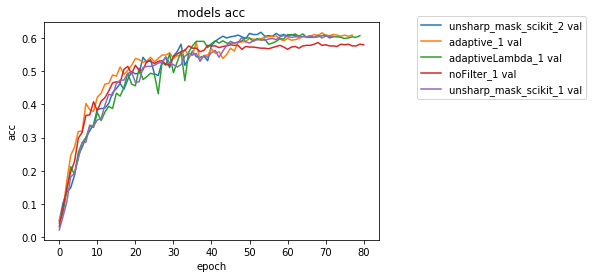

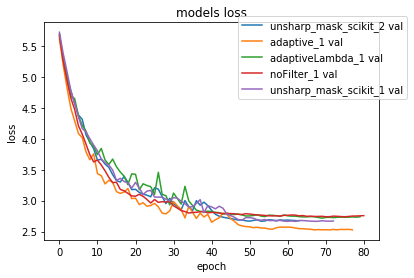

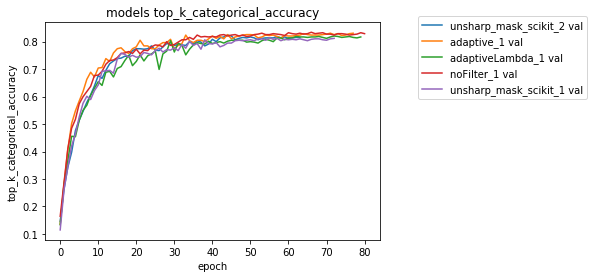

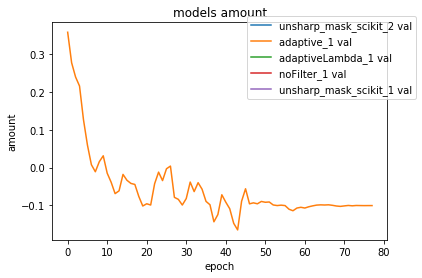

In [137]:
plot_metrics(resnet_34_maderas, list(resnet_34_maderas.index))

### resnet_50

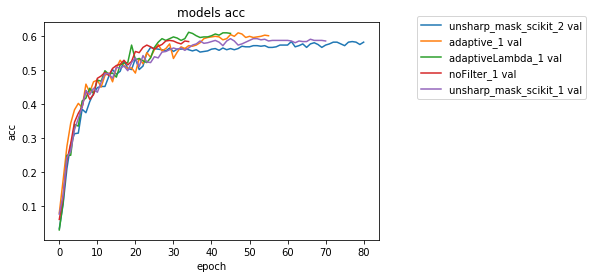

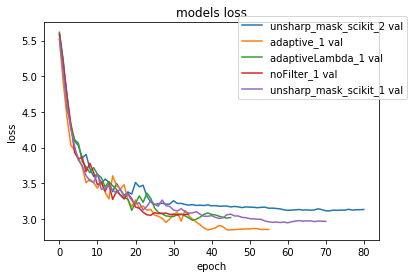

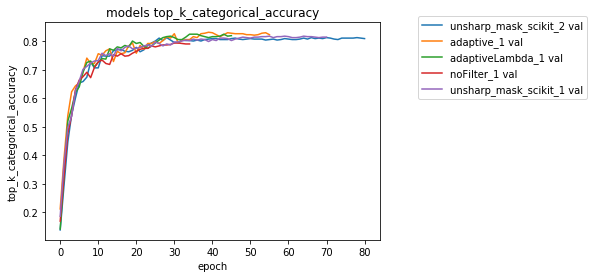

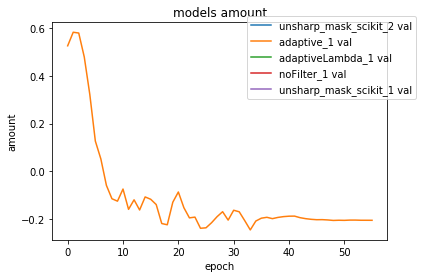

In [138]:
plot_metrics(resnet_50_maderas, list(resnet_50_maderas.index))

### mobile_net

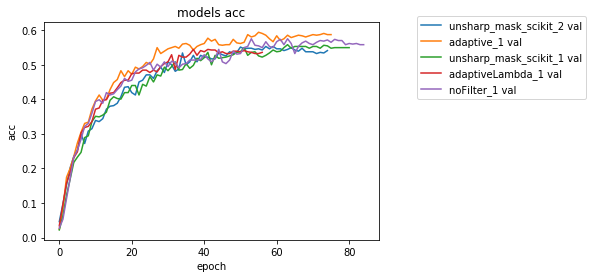

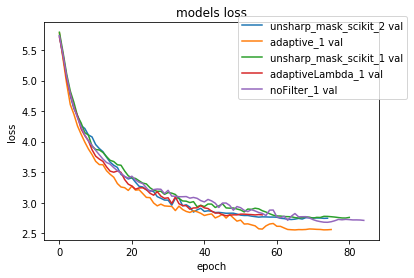

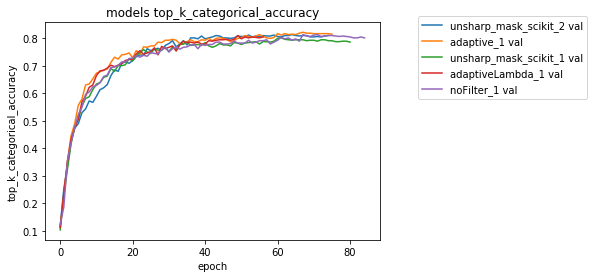

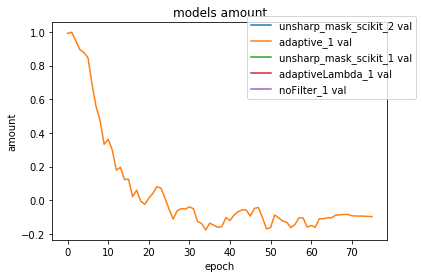

In [139]:
plot_metrics(mobile_net_maderas, list(mobile_net_maderas.index))

## Guyana Francesa dataset

In [19]:
#experiments_paths_fine_tuning = get_experiments_path('/notebooks/experiments_bdfr',  ['grid_07-07-2020_03:16:30', 'grid_07-07-2020_10:19:05', 'grid_07-07-2020_12:20:34'])

#df_results_guyana_fine_tuning = process_experiments(experiments_paths_fine_tuning)
df_results_guyana_fine_tuning = pd.read_csv('/notebooks/thesis/src/metrics_guyana_fine_tuning.csv')

In [20]:
#experiments_paths_transfer = get_experiments_path('/notebooks/experiments_bdfr',  ['grid_09-07-2020_05:28:31', 'grid_09-07-2020_11:14:51', 'grid_09-07-2020_13:15:33'])

#df_results_guyana_transfer = process_experiments(experiments_paths_transfer)
df_results_guyana_transfer = pd.read_csv('/notebooks/thesis/src/metrics_guyana_transfer.csv')

In [22]:
top_by_model(df_results_guyana_transfer, cols=['accuracy_crops', 'accuracy_crops_test', 'top_k_categorical_crops', 'top_k_categorical_crops_test', 'experiment_path'])

accuracy_crops  accuracy_crops_test  \
model_name unsharp_mask_filter                                        
mobile_net adaptive                    0.21887              0.22360   
           adaptiveLambda              0.23240              0.23856   
           adaptiveLog                 0.22127              0.22475   
           noFilter                    0.22867              0.23091   
           unsharp_mask_scikit         0.20464              0.20503   
resnet_34  adaptive                    0.21198              0.21360   
           adaptiveLambda              0.19996              0.20376   
           adaptiveLog                 0.18864              0.19186   
           noFilter                    0.20951              0.20963   
           unsharp_mask_scikit         0.20363              0.20204   
resnet_50  adaptive                    0.27433              0.27881   
           adaptiveLambda              0.28186              0.28755   
           adaptiveLog                 0.25985              0.26547   
           noFilter                    0.27186              0.28042   
           unsharp_mask_scikit         0.28078              0.27346   

                                top_k_categorical_crops  \
model_name unsharp_mask_filter                            
mobile_net adaptive                             0.59432   
           adaptiveLambda                       0.61026   
           adaptiveLog                          0.59837   
           noFilter                             0.61652   
           unsharp_mask_scikit                  0.58370   
resnet_34  adaptive                             0.59268   
           adaptiveLambda                       0.57314   
           adaptiveLog                          0.56561   
           noFilter                             0.59249   
           unsharp_mask_scikit                  0.59242   
resnet_50  adaptive                             0.67495   
           adaptiveLambda                       0.67963   
           adaptiveLog                          0.65927   
           noFilter                             0.66717   
           unsharp_mask_scikit                  0.68475   

                                top_k_categorical_crops_test  \
model_name unsharp_mask_filter                                 
mobile_net adaptive                                  0.59564   
           adaptiveLambda                            0.61272   
           adaptiveLog                               0.59282   
           noFilter                                  0.60651   
           unsharp_mask_scikit                       0.58874   
resnet_34  adaptive                                  0.59069   
           adaptiveLambda                            0.58121   
           adaptiveLog                               0.56297   
           noFilter                                  0.59599   
           unsharp_mask_scikit                       0.58862   
resnet_50  adaptive                                  0.66304   
           adaptiveLambda                            0.67299   
           adaptiveLog                               0.65338   
           noFilter                                  0.66839   
           unsharp_mask_scikit                       0.67081   

                                                                                                                              experiment_path  
model_name unsharp_mask_filter                                                                                                                 
mobile_net adaptive             /notebooks/experiments_bdfr/grid_09-07-2020_05:28:31/8ce56f9e-c1a9-11ea-99bf-0242ac110002-09-07-2020_06:00:54  
           adaptiveLambda       /notebooks/experiments_bdfr/grid_09-07-2020_05:28:31/fa019bea-c1ac-11ea-99bf-0242ac110002-09-07-2020_06:25:26  
           adaptiveLog          /notebooks/experiments_bdfr/grid_09-07-2020_05:28:31/06a3f440-c1a5-11ea-99bf-0242ac110002-09-07-2020_05:28:31  
           

In [23]:
top_by_model(df_results_guyana_transfer, cols=['accuracy_multi_crops', 'accuracy_multi_crops_test', 'top_k_categorical_multi_crops', 'top_k_categorical_multi_crops_test', 'experiment_path'])

accuracy_multi_crops  \
model_name unsharp_mask_filter                         
mobile_net adaptive                          0.32043   
           adaptiveLambda                    0.33637   
           adaptiveLog                       0.31986   
           noFilter                          0.35003   
           unsharp_mask_scikit               0.28515   
resnet_34  adaptive                          0.30848   
           adaptiveLambda                    0.29368   
           adaptiveLog                       0.28173   
           noFilter                          0.30165   
           unsharp_mask_scikit               0.29425   
resnet_50  adaptive                          0.39101   
           adaptiveLambda                    0.39954   
           adaptiveLog                       0.37279   
           noFilter                          0.37735   
           unsharp_mask_scikit               0.39499   

                                accuracy_multi_crops_test  \
model_name unsharp_mask_filter                              
mobile_net adaptive                               0.31211   
           adaptiveLambda                         0.33333   
           adaptiveLog                            0.32039   
           noFilter                               0.33230   
           unsharp_mask_scikit                    0.28209   
resnet_34  adaptive                               0.29762   
           adaptiveLambda                         0.28416   
           adaptiveLog                            0.25776   
           noFilter                               0.29503   
           unsharp_mask_scikit                    0.27019   
resnet_50  adaptive                               0.37940   
           adaptiveLambda                         0.39493   
           adaptiveLog                            0.36335   
           noFilter                               0.38043   
           unsharp_mask_scikit                    0.37992   

                                top_k_categorical_multi_crops  \
model_name unsharp_mask_filter                                  
mobile_net adaptive                                   0.71144   
           adaptiveLambda                             0.73876   
           adaptiveLog                                0.70803   
           noFilter                                   0.73193   
           unsharp_mask_scikit                        0.68754   
resnet_34  adaptive                                   0.68924   
           adaptiveLambda                             0.67900   
           adaptiveLog                                0.67046   
           noFilter                                   0.69835   
           unsharp_mask_scikit                        0.69550   
resnet_50  adaptive                                   0.78828   
           adaptiveLambda                             0.79169   
           adaptiveLog                                0.76380   
           noFilter                                   0.77575   
           unsharp_mask_scikit                        0.78543   

                                top_k_categorical_multi_crops_test  \
model_name unsharp_mask_filter                                       
mobile_net adaptive                                        0.69513   
           adaptiveLambda                                  0.71532   
           adaptiveLog                                     0.68944   
           noFilter                                        0.70497   
           unsharp_mask_scikit                             0.69720   
resnet_34  adaptive                                        0.68116   
           adaptiveLambda                                  0.66925   
           adaptiveLog                                     0.65683   
           noFilter                                        0.68116   
           unsharp_mask_scikit                             0.67598   
resnet_50  adaptive                                        0.75362   
           adaptiveLambda

In [24]:
top_by_model(df_results_guyana_fine_tuning, cols=['accuracy_crops', 'accuracy_crops_test', 'top_k_categorical_crops', 'top_k_categorical_crops_test', 'experiment_path'])

accuracy_crops  accuracy_crops_test  \
model_name unsharp_mask_filter                                        
mobile_net adaptive                    0.35496              0.34328   
           adaptiveLambda              0.37792              0.35542   
           adaptiveLog                 0.35136              0.34219   
           noFilter                    0.38418              0.35870   
           unsharp_mask_scikit         0.32872              0.31033   
resnet_34  adaptive                    0.35970              0.34576   
           adaptiveLambda              0.35332              0.34409   
           adaptiveLog                 0.37033              0.35300   
           noFilter                    0.35464              0.34219   
           unsharp_mask_scikit         0.33061              0.30544   
resnet_50  adaptive                    0.41498              0.37974   
           adaptiveLambda              0.40460              0.37710   
           adaptiveLog                 0.40593              0.38297   
           noFilter                    0.39512              0.37210   
           unsharp_mask_scikit         0.36818              0.35231   

                                top_k_categorical_crops  \
model_name unsharp_mask_filter                            
mobile_net adaptive                             0.75969   
           adaptiveLambda                       0.76772   
           adaptiveLog                          0.75387   
           noFilter                             0.77556   
           unsharp_mask_scikit                  0.73572   
resnet_34  adaptive                             0.75912   
           adaptiveLambda                       0.75855   
           adaptiveLog                          0.76987   
           noFilter                             0.75463   
           unsharp_mask_scikit                  0.73939   
resnet_50  adaptive                             0.78815   
           adaptiveLambda                       0.78315   
           adaptiveLog                          0.78499   
           noFilter                             0.76690   
           unsharp_mask_scikit                  0.76007   

                                top_k_categorical_crops_test  \
model_name unsharp_mask_filter                                 
mobile_net adaptive                                  0.71745   
           adaptiveLambda                            0.72786   
           adaptiveLog                               0.72101   
           noFilter                                  0.72780   
           unsharp_mask_scikit                       0.69928   
resnet_34  adaptive                                  0.72182   
           adaptiveLambda                            0.71716   
           adaptiveLog                               0.71860   
           noFilter                                  0.71687   
           unsharp_mask_scikit                       0.69709   
resnet_50  adaptive                                  0.74747   
           adaptiveLambda                            0.74753   
           adaptiveLog                               0.74948   
           noFilter                                  0.73280   
           unsharp_mask_scikit                       0.72734   

                                                                                                                              experiment_path  
model_name unsharp_mask_filter                                                                                                                 
mobile_net adaptive             /notebooks/experiments_bdfr/grid_07-07-2020_03:16:30/208b5cf4-c006-11ea-8c5b-0242ac110002-07-07-2020_03:58:33  
           adaptiveLambda       /notebooks/experiments_bdfr/grid_07-07-2020_03:16:30/b6ddd708-c00c-11ea-8c5b-0242ac110002-07-07-2020_04:45:42  
           adaptiveLog          /notebooks/experiments_bdfr/grid_07-07-2020_03:16:30/40b1f35e-c000-11ea-8c5b-0242ac110002-07-07-2020_03:16:30  
           

In [25]:
top_by_model(df_results_guyana_fine_tuning, cols=['accuracy_multi_crops', 'accuracy_multi_crops_test', 'top_k_categorical_multi_crops', 'top_k_categorical_multi_crops_test', 'experiment_path'])

accuracy_multi_crops  \
model_name unsharp_mask_filter                         
mobile_net adaptive                          0.50939   
           adaptiveLambda                    0.52476   
           adaptiveLog                       0.50028   
           noFilter                          0.54582   
           unsharp_mask_scikit               0.47126   
resnet_34  adaptive                          0.50882   
           adaptiveLambda                    0.50199   
           adaptiveLog                       0.53785   
           noFilter                          0.49118   
           unsharp_mask_scikit               0.46955   
resnet_50  adaptive                          0.57940   
           adaptiveLambda                    0.56232   
           adaptiveLog                       0.56346   
           noFilter                          0.54126   
           unsharp_mask_scikit               0.51679   

                                accuracy_multi_crops_test  \
model_name unsharp_mask_filter                              
mobile_net adaptive                               0.46170   
           adaptiveLambda                         0.48913   
           adaptiveLog                            0.46014   
           noFilter                               0.49224   
           unsharp_mask_scikit                    0.42288   
resnet_34  adaptive                               0.47464   
           adaptiveLambda                         0.47101   
           adaptiveLog                            0.48810   
           noFilter                               0.46532   
           unsharp_mask_scikit                    0.42805   
resnet_50  adaptive                               0.52381   
           adaptiveLambda                         0.51605   
           adaptiveLog                            0.51087   
           noFilter                               0.50052   
           unsharp_mask_scikit                    0.47671   

                                top_k_categorical_multi_crops  \
model_name unsharp_mask_filter                                  
mobile_net adaptive                                   0.85259   
           adaptiveLambda                             0.86227   
           adaptiveLog                                0.84234   
           noFilter                                   0.86283   
           unsharp_mask_scikit                        0.83096   
resnet_34  adaptive                                   0.84974   
           adaptiveLambda                             0.83552   
           adaptiveLog                                0.85145   
           noFilter                                   0.83438   
           unsharp_mask_scikit                        0.83381   
resnet_50  adaptive                                   0.86910   
           adaptiveLambda                             0.86170   
           adaptiveLog                                0.85828   
           noFilter                                   0.84405   
           unsharp_mask_scikit                        0.83324   

                                top_k_categorical_multi_crops_test  \
model_name unsharp_mask_filter                                       
mobile_net adaptive                                        0.80590   
           adaptiveLambda                                  0.80176   
           adaptiveLog                                     0.79969   
           noFilter                                        0.81211   
           unsharp_mask_scikit                             0.79037   
resnet_34  adaptive                                        0.80228   
           adaptiveLambda                                  0.79607   
           adaptiveLog                                     0.80383   
           noFilter                                        0.79296   
           unsharp_mask_scikit                             0.77277   
resnet_50  adaptive                                        0.82660   
           adaptiveLambda

In [143]:
resnet_34_guyana = get_result_by_model(df_results_guyana, model_name='resnet_34')
resnet_50_guyana = get_result_by_model(df_results_guyana, model_name='resnet_50')
mobile_net_guyana = get_result_by_model(df_results_guyana, model_name='mobile_net')

In [202]:
df_results_guyana_fine_tuning.groupby(['model_name', 'unsharp_mask_filter']).agg({'accuracy': max, 'accuracy_test': max})

accuracy  accuracy_test
model_name unsharp_mask_filter                         
mobile_net adaptive              0.48890        0.42961
           adaptiveLambda        0.48378        0.42702
           noFilter              0.48150        0.43996
           unsharp_mask_scikit   0.50655        0.45031
resnet_34  adaptive              0.44508        0.44151
           adaptiveLambda        0.44508        0.42236
           noFilter              0.46329        0.42236
           unsharp_mask_scikit   0.46101        0.42805
resnet_50  adaptive              0.52419        0.46946
           adaptiveLambda        0.50313        0.46636
           noFilter              0.50825        0.47360
           unsharp_mask_scikit   0.51338        0.46843

In [152]:
resnet_34_guyana[['accuracy','model_name', 'unsharp_mask_filter']]

,accuracy,model_name,unsharp_mask_filter
7,0.46329,resnet_34,noFilter
10,0.46101,resnet_34,unsharp_mask_scikit
2,0.44508,resnet_34,adaptive
3,0.44508,resnet_34,adaptiveLambda
13,0.44052,resnet_34,unsharp_mask_scikit


In [153]:
resnet_50_guyana[['accuracy','model_name', 'unsharp_mask_filter']]

,accuracy,model_name,unsharp_mask_filter
4,0.52419,resnet_50,adaptive
9,0.51338,resnet_50,unsharp_mask_scikit
12,0.51167,resnet_50,unsharp_mask_scikit
6,0.50825,resnet_50,noFilter
1,0.50313,resnet_50,adaptiveLambda


In [154]:
mobile_net_guyana[['accuracy','model_name', 'unsharp_mask_filter']]

,accuracy,model_name,unsharp_mask_filter
11,0.50655,mobile_net,unsharp_mask_scikit
14,0.50541,mobile_net,unsharp_mask_scikit
5,0.48890,mobile_net,adaptive
0,0.48378,mobile_net,adaptiveLambda
8,0.48150,mobile_net,noFilter


### resnet_34

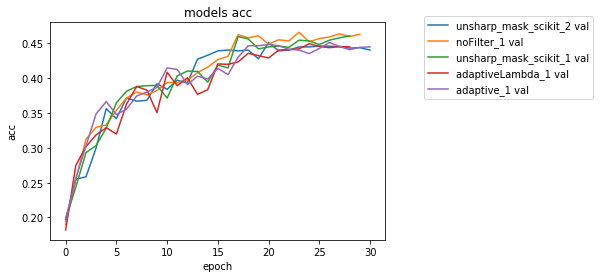

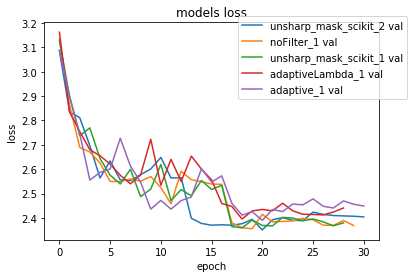

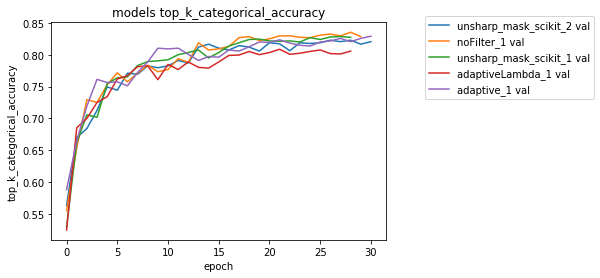

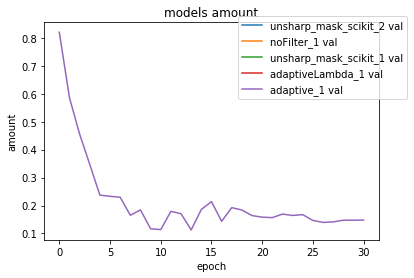

In [144]:
plot_metrics(resnet_34_guyana, list(resnet_34_guyana.index))

### resnet_50

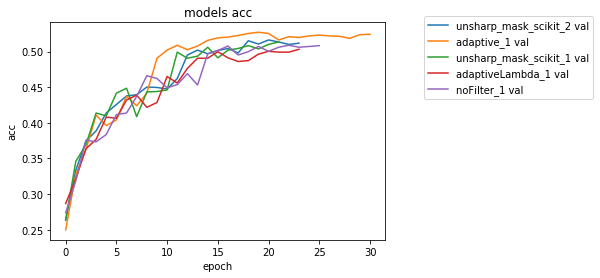

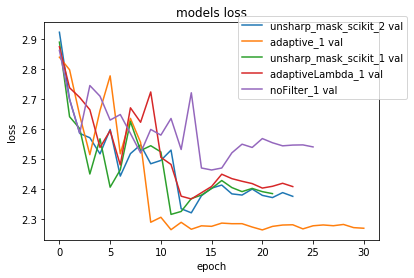

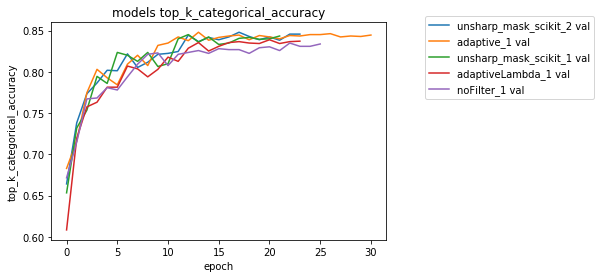

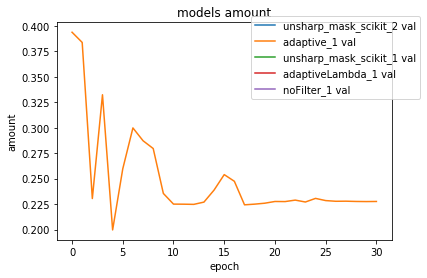

In [145]:
plot_metrics(resnet_50_guyana, list(resnet_50_guyana.index))

### mobile_net

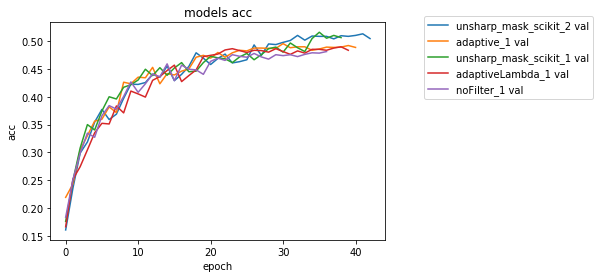

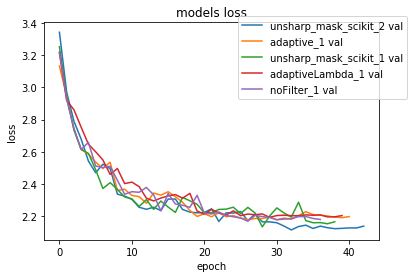

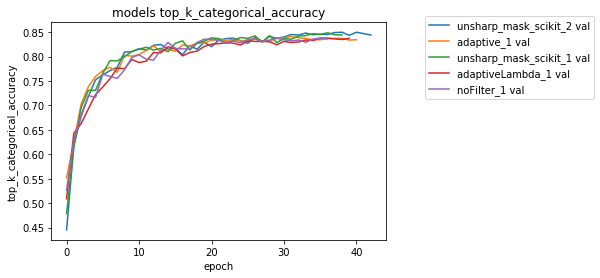

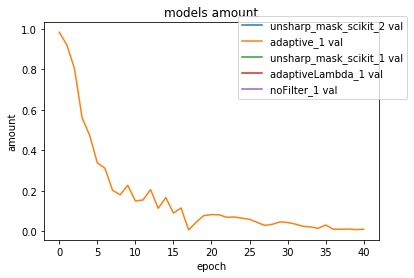

In [146]:
plot_metrics(mobile_net_guyana, list(mobile_net_guyana.index))